In [1]:
%matplotlib inline
#inline magic command to make sure all pictures are in line with each cell

#Installing libraries
print("INSTALLING LIBRARIES....")
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.preprocessing.image import img_to_array
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont
import matplotlib.patches as patches
import random
print("LIBRARIES INSTALLED!")

INSTALLING LIBRARIES....


2023-02-20 13:48:03.774768: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


LIBRARIES INSTALLED!


In [2]:
#Importing preprocess library defined by Author: Ishaipiriyan Karunakularatnam
import preprocess_dataset as pre

INSTALLING LIBRARIES....
LIBRARIES INSTALLED!


FileNotFoundError: [Errno 2] No such file or directory: './cord-v2/data/train-00000-of-00004-b4aaeceff1d90ecb.parquet'

# Pre-Processing the dataset

In [ ]:
MAX_LABELS = 22
IMG_SIZE = 512

In [ ]:
src_path = "./cord-v2/data/"
pre.setMaxLabels(MAX_LABELS)
pre.setImgSize(IMG_SIZE)
tImages, tLabels = pre.getTrainDataset(src_path)

In [5]:
print("Pre-processing the datasets...")

train_images, (train_bboxes, train_conf_scores) = pre.pre_process_images(tImages), pre.pre_process_labels(tLabels, dense=True)

print("Training Data: Processed")

Pre-processing the datasets...
Training Data: Processed


In [12]:
train_conf_scores[1]

array([1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

# Model

In [15]:
#CORE CONSTANTS
IMG_INDEX = 1 #Min is 0, Max is 799
BATCH = 16
EPOCHS = 50
L_RATE = 0.001

In [16]:
training_dataset = tf.data.Dataset.from_tensor_slices((train_images,(train_conf_scores, train_bboxes)))
training_dataset = training_dataset.shuffle(buffer_size=len(train_images))
training_dataset = training_dataset.batch(BATCH)
training_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), (TensorSpec(shape=(None, 22), dtype=tf.int64, name=None), TensorSpec(shape=(None, 22, 4), dtype=tf.float64, name=None)))>

In [10]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from keras import backend
import tensorflow_addons as tfa

In [13]:
def custom_focal_loss(gamma=2, alpha=0.25):
    def focal_loss(y_true, y_pred):
        # Filter positive examples
        positive_mask = backend.equal(y_true, 1)
        # Calculate binary cross-entropy loss
        bce = backend.binary_crossentropy(y_true, y_pred)
        # Calculate predicted probability of the positive class
        p_t = y_pred * mask + (1 - y_pred) * (1 - mask)
        # Calculate modulating factor
        modulating_factor = backend.pow(1 - p_t, gamma)
        # Calculate focal loss
        fl = alpha * modulating_factor * bce
        # Calculate the average loss for positive examples
        loss = backend.sum(fl) / backend.maximum(backend.sum(mask), 1)
        return loss
    return focal_loss

In [14]:
func = custom_focal_loss()
a = [1,1,1,0,0,0,0,0]
b = [0.3,0.1,0.2,0.6,0.7,0.6,0.7,0.8]

func(a,b)

InvalidArgumentError: cannot compute Mul as input #1(zero-based) was expected to be a int32 tensor but is a float tensor [Op:Mul]

In [47]:
def getFeatureExtracter():
    # Defining the input layer
    input_layer = Input(shape=(IMG_SIZE, IMG_SIZE, 3))

    # Using vgg16 as the feature extractor
    featureExtractor = VGG16(weights="imagenet", include_top=False, input_tensor=input_layer)
    
    return input_layer, featureExtractor

In [48]:
def getModel():
    num_labels = MAX_LABELS
    
    input_layer, fe_layer = getFeatureExtracter()
    
    x = fe_layer.output
    x = Flatten()(x)
    x = Dense(512, activation="relu")(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation="relu")(x)
    x = Dropout(0.5)(x)
    
    confScores = Dense(1 * num_labels, activation="sigmoid", name="Confidence_Scores")(x)
    Bbox_coords = Dense(4 * num_labels, activation="sigmoid", name="BBox_regression")(x)
    Bbox_coords_RS = Reshape((num_labels, 4), name="Bbox")(Bbox_coords)
    
    model = Model(inputs=input_layer, outputs=[confScores, Bbox_coords_RS])
    
    model.compile(optimizer="adam", loss=["binary_crossentropy", "mse"], metrics=["accuracy"])
    return model
    
    

In [49]:
def train(save_path, dataset, epoch_range):
    model = getModel()
    
    callback_cp = tf.keras.callbacks.ModelCheckpoint(
        filepath=save_path, verbose=1, save_weights_only=True,
        save_freq= "epoch")
    
    train_history = model.fit(dataset, batch_size=BATCH, callbacks = [callback_cp], epochs=epoch_range)
    
    return model, train_history

In [50]:
sample_model = getModel()

In [51]:
sample_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 256, 256, 64  1792        ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv2 (Conv2D)          (None, 256, 256, 64  36928       ['block1_conv1[0][0]']           
                                )                                                           

In [52]:
save_path = "./Saved Model/DO_Detection_VGG16_Focal_loss/"

In [53]:
model, history = train(save_path, training_dataset, epoch_range=10)

Epoch 1/10


ValueError: in user code:

    File "/Users/piriyan_karu/opt/anaconda3/envs/ip-mac/lib/python3.10/site-packages/keras/engine/training.py", line 1160, in train_function  *
        return step_function(self, iterator)
    File "/Users/piriyan_karu/opt/anaconda3/envs/ip-mac/lib/python3.10/site-packages/keras/engine/training.py", line 1146, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/piriyan_karu/opt/anaconda3/envs/ip-mac/lib/python3.10/site-packages/keras/engine/training.py", line 1135, in run_step  **
        outputs = model.train_step(data)
    File "/Users/piriyan_karu/opt/anaconda3/envs/ip-mac/lib/python3.10/site-packages/keras/engine/training.py", line 994, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "/Users/piriyan_karu/opt/anaconda3/envs/ip-mac/lib/python3.10/site-packages/keras/engine/training.py", line 1052, in compute_loss
        return self.compiled_loss(
    File "/Users/piriyan_karu/opt/anaconda3/envs/ip-mac/lib/python3.10/site-packages/keras/engine/compile_utils.py", line 316, in __call__
        total_total_loss_mean_value = tf.add_n(total_loss_mean_values)

    ValueError: Shapes must be equal rank, but are 1 and 0
    	From merging shape 0 with other shapes. for '{{node AddN}} = AddN[N=2, T=DT_FLOAT](sigmoid_focal_crossentropy/weighted_loss/Mul, mean_squared_error/weighted_loss/value)' with input shapes: [?], [].


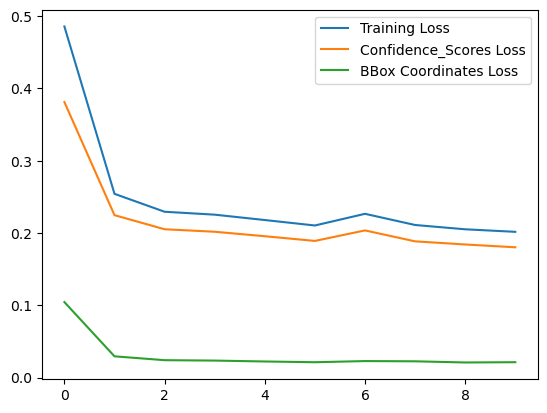

In [25]:
epochs_range = range(10)

plt.plot(epochs_range, history.history["loss"], label='Training Loss')
plt.plot(epochs_range, history.history["Confidence_Scores_loss"], label='Confidence_Scores Loss')
plt.plot(epochs_range, history.history["Bbox_loss"], label='BBox Coordinates Loss')
plt.legend(loc='upper right')
plt.show()

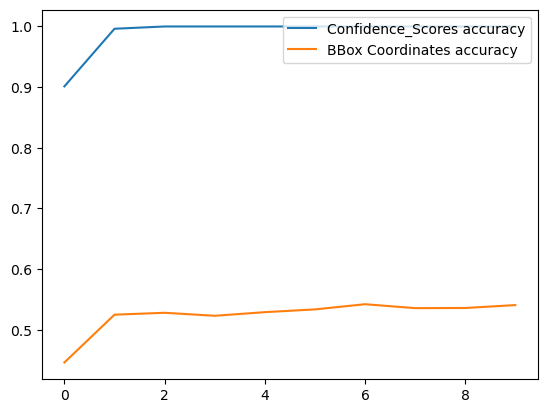

In [26]:
plt.plot(epochs_range, history.history["Confidence_Scores_accuracy"], label='Confidence_Scores accuracy')
plt.plot(epochs_range, history.history["Bbox_accuracy"], label='BBox Coordinates accuracy')
plt.legend(loc='upper right')
plt.show()

In [27]:
history.history.keys()

dict_keys(['loss', 'Confidence_Scores_loss', 'Bbox_loss', 'Confidence_Scores_accuracy', 'Bbox_accuracy'])

In [16]:
model = keras.models.load_model(save_path + "Model/")

In [18]:
test_images, test_labels = pre.getTestDataset(src_path)

checkpoint = ModelCheckpoint(
    filepath="./checkpoint",
    save_weights_only=True,
    monitor="val_loss",
    mode="min",
    save_best_only=True
) 

In [38]:
def unnormalize(box, width, height):
    return [
        box[0] * width,
        box[1] * height,
        box[2] * width,
        box[3] * height
    ]

def test_image(idx):
    test_data = test_images[idx]
    tl = eval(test_labels[idx])
    w,h = tl['meta']['image_size']['width'], tl['meta']['image_size']['height']

    test_data = img_to_array(test_data.resize((IMG_SIZE,IMG_SIZE)))
    test_data = np.expand_dims(test_data, axis=0)
    
    preds = model.predict(test_data)
    
    isPos, dBox = preds
    boxes = []
    poses = []
    for index, i in enumerate(isPos[0]):
        if i >= 0.4:
            boxes.append(dBox[0][index])
            poses.append(i)
    
    norm_boxes = [unnormalize(box, w, h) for box in boxes]
    
    fig, ax = plt.subplots()

    ax.imshow(test_images[idx])
    for i in norm_boxes:
        x1,y1,x3,y3 = i
        bbox = patches.Rectangle((x1, y1), (x3-x1), (y3-y1), linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(bbox)
    
    gt_bbox = pre.retreiveCoordinates(tl)
    #iou = inter_over_union(gt_bbox, box)
    
    for i in gt_bbox:
        x1,y1,x3,y3 = i
        bbox_gt = patches.Rectangle((x1, y1), (x3-x1), (y3-y1), linewidth=1, edgecolor='g', facecolor='none')
        ax.add_patch(bbox_gt)
        
    plt.title("WxH: ({0},{1})".format(w, h))
    plt.axis('off')
    plt.show()

1/1 [==============================] - 0s 210ms/step


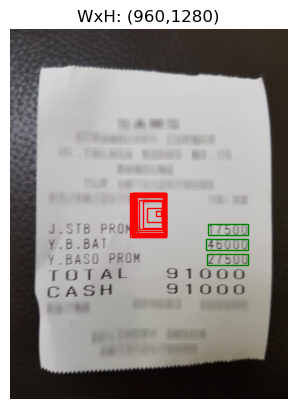

In [39]:
test_image(1)

1/1 [==============================] - 0s 167ms/step


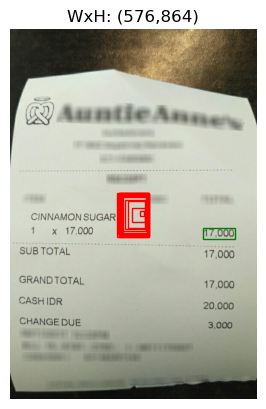

In [40]:
test_image(10)

1/1 [==============================] - 0s 165ms/step


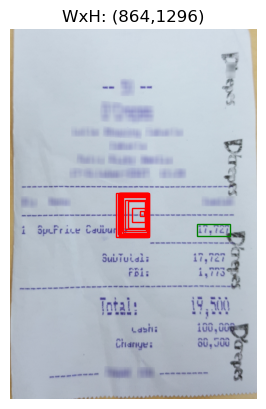

In [41]:
test_image(50)

1/1 [==============================] - 0s 168ms/step


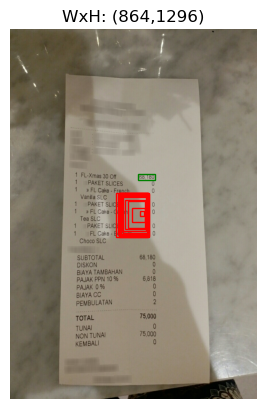

In [42]:
test_image(99)

In [43]:
#model.save("./Save-Models/Initial-Base-Model/")

In [44]:
# Need to define custom loss function to penalize 1 conf data and not 0 conf data